Querying some models can be very expensive, taking up to a couple of hours for one input. Hence, algorithms requiring numerous queries from the model become impractical. To solve this problem, it's usefull to create an emulator. Emulator is a new model, trained on the queries from the original model, that can be queried for unobserved inputs much more cheaply. This notebooks shows how PINTS uses emulators to model the log_likelihood of a given model.

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt
import GPy

import pints.emulator as emulator
import pints.emulator.utils as emutils
import pints.emulator.plot as emuplt

%matplotlib inline

# Creating the model 

In this notebook we consider the Logistic model.
Logistic ODE:

In [2]:
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Create bounds for our parameters
boundaries = pints.Boundaries([0.01, 400], [0.02, 600])


# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

In [3]:
# Create a uniform prior over parameters
log_prior = pints.UniformLogPrior(
    boundaries
)

# Generating data

Emulator accepts as input array of shape $N \times n\_parameters$ and a target array of shape $N \times 1$. 
To train the emulator we generate 400 data points by sampling them from the prior

In [4]:
input_parameters = log_prior.sample(400)
input_parameters[:5]

array([[1.84037694e-02, 4.72529545e+02],
       [1.45360124e-02, 4.49604395e+02],
       [1.54771211e-02, 4.85718315e+02],
       [1.11496801e-02, 5.25127970e+02],
       [1.58683422e-02, 5.39739087e+02]])

In [5]:
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

array([-17229.00431244, -11525.30070793,  -4336.33361192, -42720.58961676,
       -11309.52586818])

## Create and train a GP emulator

To create an emulator we need to give an instance of the distribution, as well as the data for training, which consists of matrix of inputs and an array of the corresponding targets. <br>
When using Gaussian Processes we standardize log_likelihoods, this helps GP to get a better fit as it assume that the mean of the GP is 0, so it helps if the input data meets this criteria. Standardizing inputs is also usefull, as it helps to select initial parameters for the covariance function.

In [6]:
emu = emulator.GPEmulator(log_likelihood, input_parameters, likelihoods,
                      normalize_input = True)
emu.set_parameters(kernel = GPy.kern.Linear(emu.n_parameters()) )
emu.fit(normalizer = True)
emu.summary()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   5.835615e+02   1.460098e+04 
    00s16  0014   5.424098e+02   7.632091e-04 
    00s19  0017   5.424098e+02   2.670722e-08 
Runtime:     00s19
Optimization status: Converged

Summary
Kernel:
   linear.    |                value  |  constraints  |  priors
  variances  |  0.06779183801605314  |      +ve      |        
Model:  <class 'GPy.models.gp_regression.GPRegression'>
Optimizer:  default

Name : GP regression
Objective : 542.4098039995741
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  linear.variances         |  0.06779183801605314  |      +ve      |        
  Gaussian_noise.variance  |   0.8665825369669659  |      +ve      |        


Now we can query prediction from the emulator just like we can from any log-pdf

In [7]:
emu([0.015, 500])

array([[-29339.18399923]])

## Surface plots

To visuallize the performance of our emulator it's usefull to look at the surface plots <br>

In [8]:
test_splits = 20
r_grid, k_grid, test_data = emutils.generate_grid(boundaries.lower(), 
                                                  boundaries.upper(), 
                                                  test_splits)
test_data[0, :5]

array([[1.00000000e-02, 4.00000000e+02],
       [1.05263158e-02, 4.00000000e+02],
       [1.10526316e-02, 4.00000000e+02],
       [1.15789474e-02, 4.00000000e+02],
       [1.21052632e-02, 4.00000000e+02]])

In [9]:
model_prediction = emutils.predict_grid(log_likelihood, test_data)
model_prediction.shape

(20, 20)

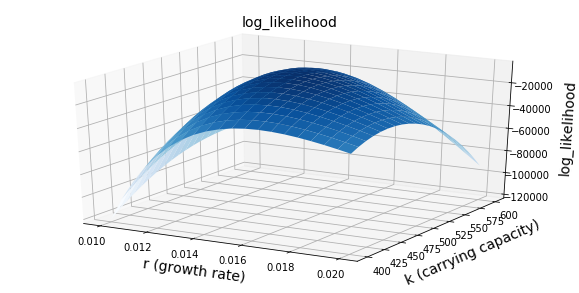

In [10]:
plt.figure(figsize = (10, 5))
emuplt.surface(r_grid, k_grid, model_prediction, title = "log_likelihood",
                     x_label = "r (growth rate)",
                     y_label = "k (carrying capacity)")

In [11]:
emu_prediction = emutils.predict_grid(emu, test_data)
emu_prediction.shape

(20, 20)

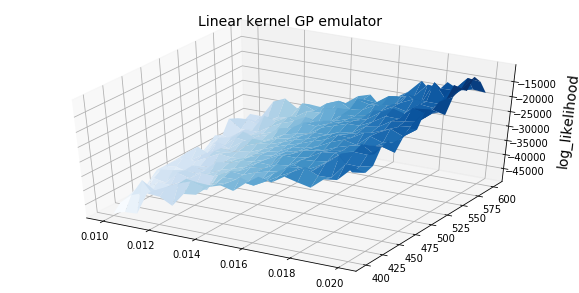

In [12]:
plt.figure(figsize = (10, 5))
emuplt.surface(r_grid, k_grid, emu_prediction, title = "Linear kernel GP emulator", angle = (40, 300))

It's helpful to plot the differences between corresponding inputs.

In [13]:
diffs = np.abs(model_prediction - emu_prediction)

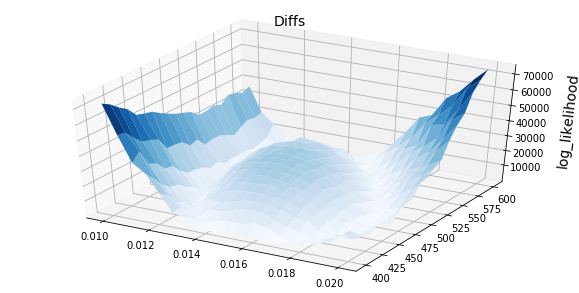

In [14]:
plt.figure(figsize = (10, 5))
emuplt.surface(r_grid, k_grid, diffs, 
                      title = "Diffs", 
                      angle = (40, 300))

## Comparison of different kernels

Now we try a number of different kernels to find out which ones fit data the best. Note, an important feature of kernels is that they can be added and multiplied together to produce new kernels. <br>
We use mean_squared error as the function by which we decide which kernel is the best. 

In [41]:
input_dim = 2
kernels_and_names = [
    (GPy.kern.White(input_dim), "White"),
    (GPy.kern.Linear(input_dim), "Linear"),
    (GPy.kern.Matern52(input_dim), "Matern52"),
    (GPy.kern.RBF(input_dim), "RBF"),
    (GPy.kern.MLP(input_dim), "MLP"),
    (GPy.kern.RatQuad(input_dim), "RatQuad"),
    # combinations
    (GPy.kern.Linear(input_dim) * GPy.kern.Linear(input_dim) + GPy.kern.White(input_dim), "Linear * Linear + White"),
    (GPy.kern.RBF(input_dim) * GPy.kern.RBF(input_dim), "RBF * RBF"),
    # adding these 2 kernels seems very effective
    (GPy.kern.Matern52(input_dim, variance = 1.) + GPy.kern.RBF(input_dim, variance = 1.), "Matern52 + RBF"),
    (GPy.kern.RBF(input_dim) + GPy.kern.RBF(input_dim, lengthscale = 0.01) * GPy.kern.RBF(input_dim), 
     "RBF + RBF[variance=0.01]*RBF"),
]

# differents optimizers:
# SCG
# possible optimizers: ‘scg’, ‘lbfgs’, ‘tnc’.
# 'scg' and 'tnc' require the data to be normalized
#  can put the max on the number of iterations using max_iter = 100
# 'lbfgs' seems to be the default and performs well for MLP and RatQuad
optimizer = 'lbfgs'
emu.set_parameters(optimizer=optimizer)

# error function
def mean_squared_error(gp_prediction, model_prediction):
    assert gp_prediction.shape == model_prediction.shape
    return np.sum(np.square(gp_prediction - model_prediction)) / gp_prediction.size

 /anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:588: RuntimeWarning:covariance is not positive-semidefinite.
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:526: RuntimeWarning:overflow encountered in multiply
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:526: RuntimeWarning:overflow encountered in square
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:526: RuntimeWarning:invalid value encountered in multiply


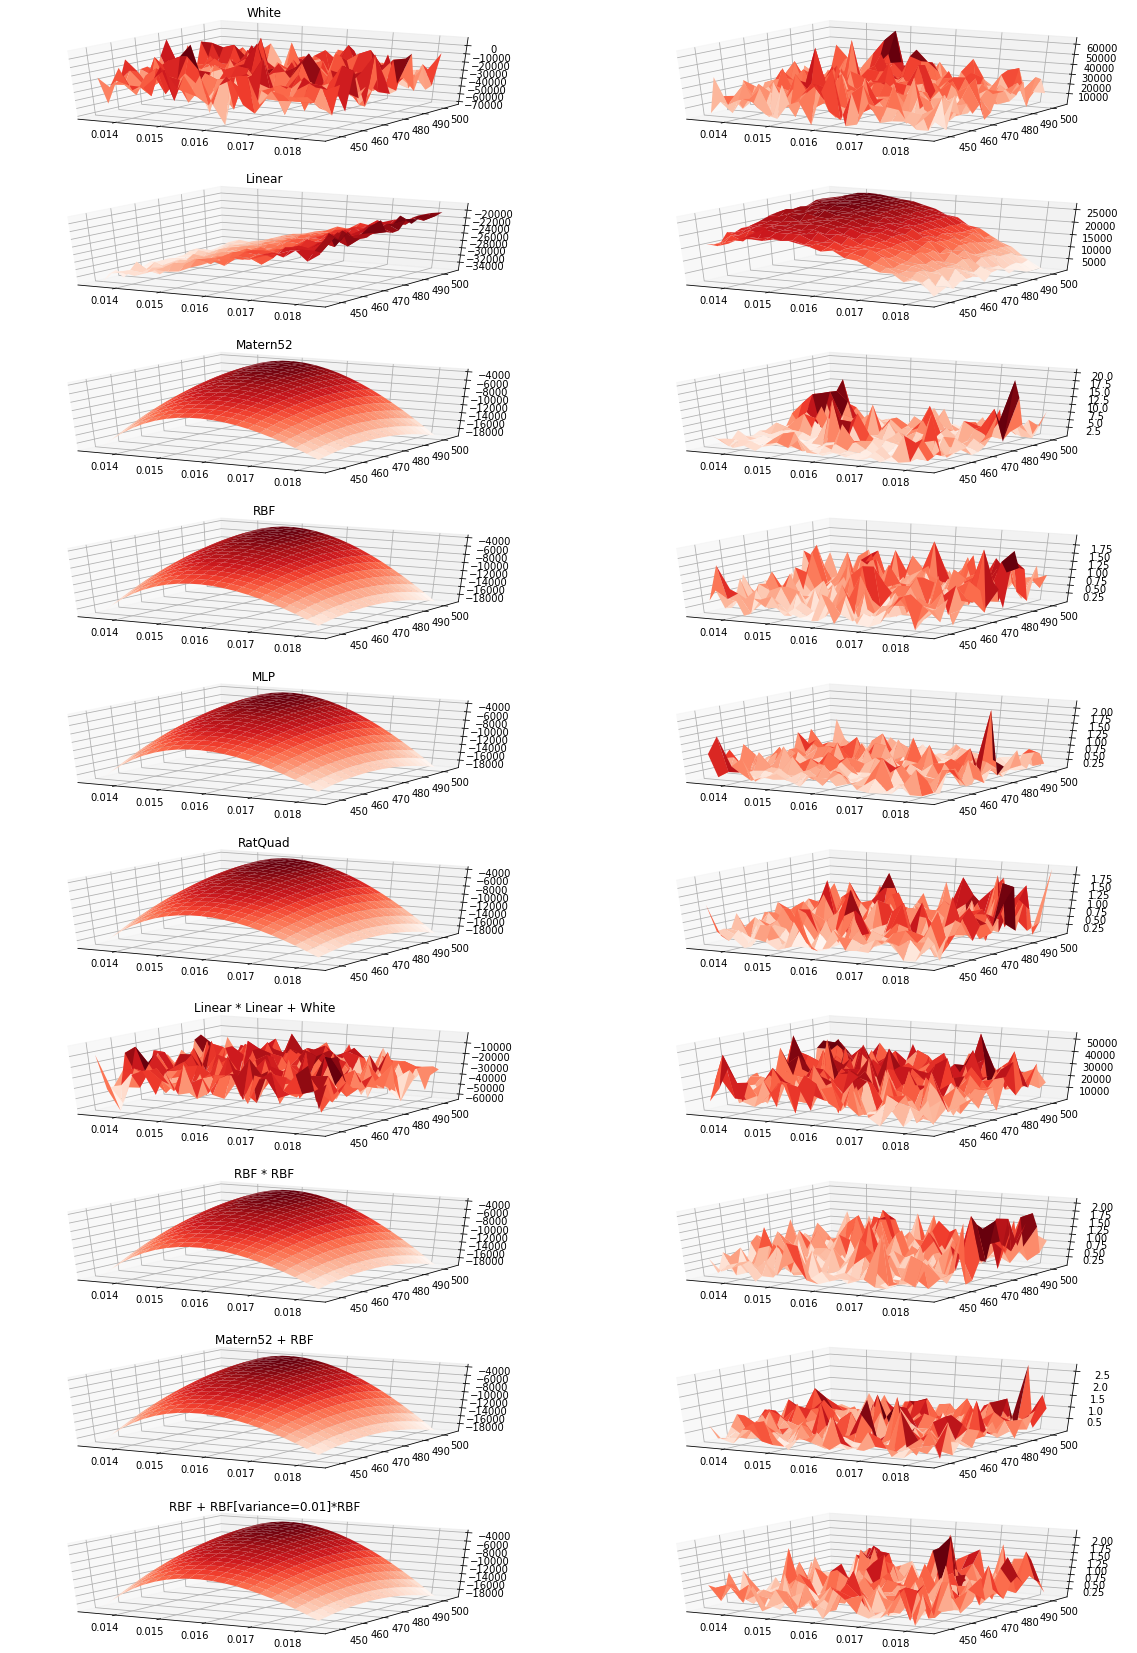

In [42]:
l = len(kernels_and_names)

errors = []

fig = plt.figure(figsize = (20, 30))

for row in range(l):

    kernel, name = kernels_and_names[row]
    
    
    emu.set_parameters(kernel = kernel)
    emu.fit(messages = False, normalizer = True) # change of parameters requires the model to be refitted
    emu_prediction = emutils.predict_grid(emu, test_data)
    diffs = np.abs(model_prediction - emu_prediction)
    
    # store errors
    errors.append(emu.get_log_marginal_likelihood())
    
    # plot surface of GP
    gp = emu.get_gp()
    ax1 = fig.add_subplot(l, 2, 2*row + 1, projection = '3d')
    #ax1.set_zlim(-800000, 0)
    ax1.set_title(name)
    ax1.plot_surface(r_grid, k_grid, emu_prediction, cmap = "Reds")
    
    # plot surface of 
    ax2 = fig.add_subplot(l, 2, 2*row + 2, projection = '3d')
    #ax2.set_zlim(0, 700000)
    ax2.plot_surface(r_grid, k_grid, diffs, cmap = "Reds")

Most non-basic kernels perform pretty well, although all of them find it hard to capture the peak value when r is close to zero

In [17]:
errors

[-542.4098039995741,
 2412.088034720502,
 2963.084900042851,
 2921.7358998330546,
 2967.253212431515,
 -454.602479891475,
 1466.3795910110516,
 2963.082206206133,
 2930.669311824212,
 2963.090962906579]

In [18]:
optimal_ker = kernels_and_names[np.argmax(errors)][0]
optimal_ker

RatQuad.,value,constraints,priors
variance,12276.139118062438,+ve,
lengthscale,20.232321576770623,+ve,
power,24.448821844439447,+ve,


In [19]:
emu.set_parameters(kernel = optimal_ker)
emu.fit(normalizer = True)
emu_prediction = emutils.predict_grid(emu, test_data)
emu.summary()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   4.160123e+02   1.486475e+04 
    00s09  0009  -2.967210e+03   2.020078e-01 
    00s18  0019  -2.970180e+03   2.820596e+01 

 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0020  -2.931794e+03   1.037769e+04 
    00s73  0087  -2.978070e+03   3.385896e-04 
Runtime:     00s73
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'

Summary
Kernel:
   RatQuad.     |               value  |  constraints  |  priors
  variance     |  12276.144041395459  |      +ve      |        
  lengthscale  |   7.241381191786596  |      +ve      |        
  power        |  1.0160833737981696  |      +ve      |        
Model:  <class 'GPy.models.gp_regression.GPRegression'>
Optimizer:  lbfgs

Name : GP regression
Objective : -2978.0700173968507
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  RatQuad.variance         |    12276.144041395459  |      +ve      |        
  RatQuad.lengthscale      |     7.241381191786596  |      +ve      |        
  RatQuad.power            |    1.0160833737981696  |      +ve      |        
  Gaussian_noise.varian

## Plotting GP fit

To visualize the resulting GP it's possible to retrieve the GPy model from our class and use its built-in functions.

In [20]:
gp = emu.get_gp()

 /anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


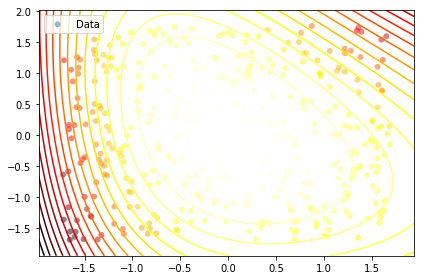

In [21]:
fig = gp.plot()
fig

# Slicing

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1f8b7208>)

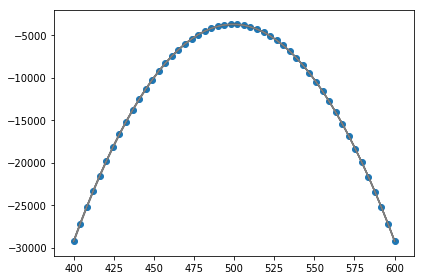

In [22]:
test_k_range = np.linspace(400, 600, 50)
r_slice_val = 0.015
r_arr = np.zeros(len(test_k_range)) + r_slice_val
slice_data = np.dstack((r_arr, test_k_range)).squeeze()
slice_data

#prediction returns mean and variance(?)
mean, var = emu.predict(slice_data)
# convert to 1D
mean, var = mean.flatten(), var.flatten()

#for 95% confidence add/subtract 2 std
conf = 2 * np.sqrt(var)


emuplt.confidence_interval(test_k_range, mean, conf)

In [23]:
test_k_range

array([400.        , 404.08163265, 408.16326531, 412.24489796,
       416.32653061, 420.40816327, 424.48979592, 428.57142857,
       432.65306122, 436.73469388, 440.81632653, 444.89795918,
       448.97959184, 453.06122449, 457.14285714, 461.2244898 ,
       465.30612245, 469.3877551 , 473.46938776, 477.55102041,
       481.63265306, 485.71428571, 489.79591837, 493.87755102,
       497.95918367, 502.04081633, 506.12244898, 510.20408163,
       514.28571429, 518.36734694, 522.44897959, 526.53061224,
       530.6122449 , 534.69387755, 538.7755102 , 542.85714286,
       546.93877551, 551.02040816, 555.10204082, 559.18367347,
       563.26530612, 567.34693878, 571.42857143, 575.51020408,
       579.59183673, 583.67346939, 587.75510204, 591.83673469,
       595.91836735, 600.        ])

## Using the emulator

In [24]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(emu, log_prior)

We use the resulting posterior as we would normally in pints

In [25]:
xs = [
    np.array(real_parameters) * 0.9,
    np.array(real_parameters) * 1.05,
    np.array(real_parameters) * 1.15,
]
xs

[array([1.35e-02, 4.50e+02]),
 array([1.575e-02, 5.250e+02]),
 array([1.725e-02, 5.750e+02])]

In [26]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0.25       0:00.0
20    63     0.0476    0.0476    0.0476     0:00.0
40    123    0.0244    0.0244    0.0244     0:00.0
60    183    0.0328    0.0164    0.0164     0:00.1
80    243    0.0247    0.0123    0.0123     0:00.1
100   303    0.0396    0.0099    0.0099     0:00.1
120   363    0.0331    0.0248    0.00826    0:00.1
140   423    0.0284    0.0213    0.00709    0:00.1
160   483    0.0248    0.0186    0.00621    0:00.2
180   543    0.0221    0.0166    0.00552    0:00.2
200   603    0.0249    0.0149    0.00995    0:00.2
220   663    0.0317    0.0226    0.0181     0:00.2
240   723    0.0456    0.029     0.0498     0:00.3
260   783    0.0843    0.0536    0.0881     0:00.3
28

3180  9543   0.307     0.308     0.314      0:07.5
3200  9603   0.307     0.308     0.314      0:07.6
3220  9663   0.306737  0.308     0.314      0:07.7
3240  9723   0.307     0.309     0.314      0:07.7
3260  9783   0.307881  0.31      0.315      0:07.8
3280  9843   0.307833  0.311     0.315      0:07.8
3300  9903   0.307     0.310209  0.315359   0:07.9
3320  9963   0.305     0.312     0.316      0:07.9
3340  10023  0.304     0.311284  0.315      0:07.9
3360  10083  0.303     0.311     0.315      0:08.0
3380  10143  0.304     0.31      0.314      0:08.0
3400  10203  0.305     0.311     0.312      0:08.1
3420  10263  0.305     0.311     0.312      0:08.2
3440  10323  0.305     0.312     0.313      0:08.2
3460  10383  0.305     0.312     0.312      0:08.3
3480  10443  0.306     0.311     0.312      0:08.3
3500  10503  0.305     0.31      0.312      0:08.4
3520  10563  0.304459  0.309     0.312      0:08.5
3540  10623  0.303869  0.309     0.311      0:08.6
3560  10683  0.304     0.308   

6400  19203  0.309     0.304     0.308      0:15.4
6420  19263  0.309     0.303     0.307896   0:15.4
6440  19323  0.309424  0.303     0.308182   0:15.5
6460  19383  0.309     0.303     0.308      0:15.5
6480  19443  0.309     0.303194  0.308      0:15.6
6500  19503  0.309     0.304     0.308      0:15.6
6520  19563  0.308695  0.304     0.308      0:15.7
6540  19623  0.308     0.304     0.308      0:15.7
6560  19683  0.308     0.304     0.307      0:15.7
6580  19743  0.308     0.304     0.307      0:15.8
6600  19803  0.308     0.304     0.307      0:15.8
6620  19863  0.308     0.304     0.307      0:15.9
6640  19923  0.308     0.304     0.307      0:15.9
6660  19983  0.308212  0.304     0.307011   0:16.0
6680  20043  0.309     0.304     0.307      0:16.0
6700  20103  0.308     0.303     0.307      0:16.1
6720  20163  0.308     0.303     0.306      0:16.1
6740  20223  0.308     0.304     0.306      0:16.2
6760  20283  0.308     0.303     0.307      0:16.2
6780  20343  0.308     0.303   

9640  28923  0.304     0.304429  0.303      0:23.2
9660  28983  0.304     0.304     0.302      0:23.3
9680  29043  0.304     0.304     0.302      0:23.4
9700  29103  0.304     0.304     0.302      0:23.5
9720  29163  0.304     0.304     0.302      0:23.5
9740  29223  0.304     0.303     0.302      0:23.6
9760  29283  0.304     0.303     0.302      0:23.7
9780  29343  0.304     0.303     0.302      0:23.7
9800  29403  0.304     0.303     0.301908   0:23.8
9820  29463  0.303     0.303     0.302      0:23.8
9840  29523  0.303     0.303     0.301      0:23.9
9860  29583  0.304     0.303     0.301      0:23.9
9880  29643  0.304     0.302     0.302      0:24.0
9900  29703  0.304     0.302     0.301      0:24.1
9920  29763  0.304304  0.302     0.301      0:24.1
9940  29823  0.304     0.303     0.302      0:24.2
9960  29883  0.304     0.303     0.302      0:24.3
9980  29943  0.305     0.302     0.301      0:24.3
10000 30000  0.3049    0.3027    0.3015     0:24.4
Halting: Maximum number of iter

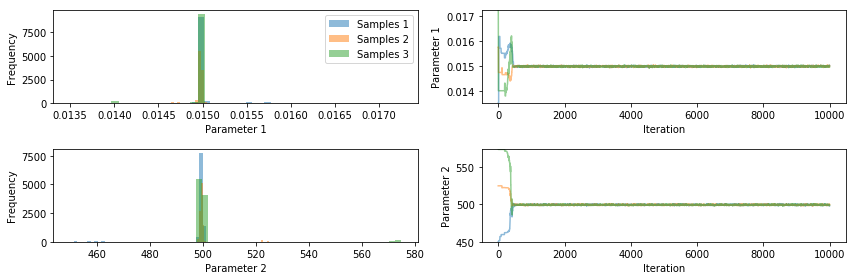

In [27]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Compare this with the parameter estimation for the original likelihood

In [28]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [29]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
20    63     0.143     0.0476    0.0476     0:00.0
40    123    0.122     0.0488    0.0732     0:00.0
60    183    0.082     0.0492    0.0656     0:00.0
80    243    0.0617    0.037     0.0494     0:00.1
100   303    0.0594    0.0396    0.0396     0:00.1
120   363    0.0496    0.0331    0.0331     0:00.1
140   423    0.0426    0.0284    0.0284     0:00.1
160   483    0.0373    0.0248    0.0248     0:00.1
180   543    0.0331    0.0221    0.0276     0:00.1
200   603    0.0299    0.0199    0.0249     0:00.1
220   663    0.0498    0.0226    0.0226     0:00.1
240   723    0.0747    0.0456    0.0332     0:00.2
260   783    0.107     0.0651    0.0766     0:00.2
28

3120  9363   0.306     0.310157  0.327      0:03.2
3140  9423   0.30468   0.311     0.327      0:03.2
3160  9483   0.305     0.311     0.328      0:03.2
3180  9543   0.305     0.312     0.327      0:03.3
3200  9603   0.305     0.314     0.327      0:03.3
3220  9663   0.305     0.315     0.327      0:03.3
3240  9723   0.305     0.316     0.326      0:03.3
3260  9783   0.306     0.316     0.325      0:03.3
3280  9843   0.306     0.316     0.326      0:03.3
3300  9903   0.305665  0.316     0.325356   0:03.3
3320  9963   0.306     0.316     0.326      0:03.4
3340  10023  0.307     0.315     0.327      0:03.4
3360  10083  0.306     0.316     0.327      0:03.4
3380  10143  0.306     0.315     0.327      0:03.4
3400  10203  0.306     0.315     0.327      0:03.4
3420  10263  0.307     0.315     0.327      0:03.4
3440  10323  0.307     0.314     0.327      0:03.4
3460  10383  0.307     0.31436   0.327362   0:03.5
3480  10443  0.307     0.315     0.326343   0:03.5
3500  10503  0.307     0.315   

6340  19023  0.305     0.306     0.315      0:06.0
6360  19083  0.305     0.306     0.315      0:06.0
6380  19143  0.305     0.305     0.315      0:06.0
6400  19203  0.305     0.305     0.314      0:06.0
6420  19263  0.305     0.305     0.314      0:06.0
6440  19323  0.305     0.305     0.315      0:06.1
6460  19383  0.304     0.305     0.315      0:06.1
6480  19443  0.304     0.305     0.315      0:06.1
6500  19503  0.304     0.305     0.315      0:06.1
6520  19563  0.305     0.305     0.315      0:06.1
6540  19623  0.305     0.305     0.316      0:06.2
6560  19683  0.305     0.304     0.316      0:06.2
6580  19743  0.305     0.304     0.316      0:06.2
6600  19803  0.305     0.303     0.316      0:06.2
6620  19863  0.304     0.303     0.316      0:06.2
6640  19923  0.305     0.303     0.316      0:06.2
6660  19983  0.305     0.303     0.316      0:06.3
6680  20043  0.305     0.303     0.316      0:06.3
6700  20103  0.305     0.302     0.315923   0:06.3
6720  20163  0.305     0.303   

9680  29043  0.302     0.301     0.307      0:08.3
9700  29103  0.302     0.301     0.307      0:08.3
9720  29163  0.302     0.301     0.307      0:08.3
9740  29223  0.301     0.302     0.307      0:08.3
9760  29283  0.301     0.302     0.307      0:08.4
9780  29343  0.301     0.302     0.307      0:08.4
9800  29403  0.301     0.302     0.308      0:08.4
9820  29463  0.302     0.302     0.307      0:08.4
9840  29523  0.301697  0.302     0.308      0:08.4
9860  29583  0.302     0.302     0.308      0:08.4
9880  29643  0.302     0.302     0.308      0:08.4
9900  29703  0.302     0.303     0.308      0:08.4
9920  29763  0.302     0.303     0.308      0:08.5
9940  29823  0.302     0.303     0.308      0:08.5
9960  29883  0.302     0.303     0.308      0:08.5
9980  29943  0.301573  0.303     0.308      0:08.5
10000 30000  0.3014    0.3029    0.3077     0:08.5
Halting: Maximum number of iterations (10000) reached.


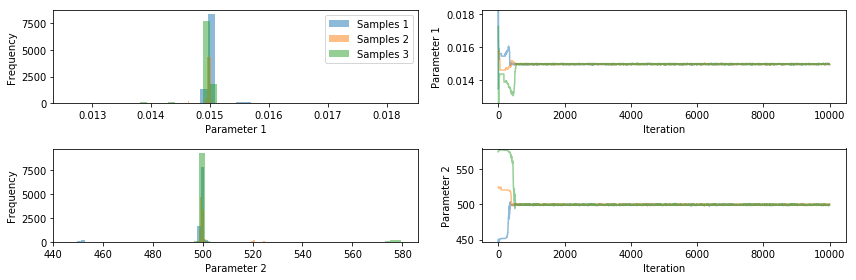

In [30]:
pints.plot.trace(chains)
plt.show()

Plotting likelihood for the required parameters

In [31]:
chain = chains[0]

In [32]:
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()

In [33]:
diffs = np.abs(model_prediction - emu_prediction)

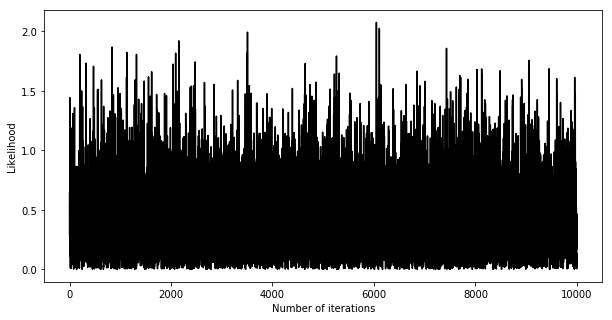

In [34]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
#plt.xlim(0, 2000)
#plt.ylim(-10000, -3000)
#plt.plot(iters, emu_prediction, color = "Red")
#plt.plot(iters, model_prediction, color = "Blue")
plt.plot(iters, diffs, color = "Black")
plt.show()

Try to plot 3D surface but for chains only <br>
Contour error plot (to see which parameters are the best) <br>
And show the progression of the chain on the countnour plot <br>
Timing on harder model <br>
Documentation

In [35]:
r_vals = chain[:, 0]
k_vals = chain[:, 1]
print(r_vals.shape, k_vals.shape)

(10000,) (10000,)


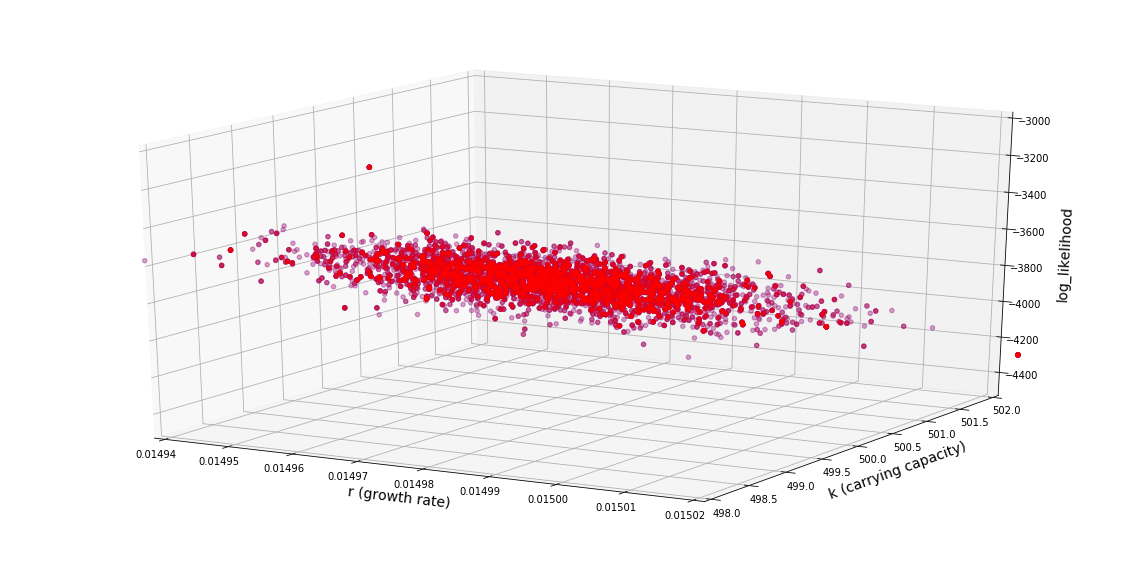

In [36]:
plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
ax.scatter(r_vals, k_vals, emu_prediction, c = "r", alpha = 0.2)
ax.scatter(r_vals, k_vals, model_prediction, c = "b", alpha = 0.2)

fontsize = 14
labelpad = 10

ax.set_ylim(498, 502)
ax.set_xlim(0.01494, 0.01502)
ax.set_zlim(-4500, -3000)

ax.set_xlabel('r (growth rate)', fontsize = fontsize, labelpad = labelpad)
ax.set_ylabel('k (carrying capacity)', fontsize = fontsize, labelpad = labelpad)
ax.set_zlabel('log_likelihood', fontsize = fontsize, labelpad = labelpad)

ax.view_init(20, 300)

In [37]:
test_split = 50
r_min, r_max = r_vals.min(), r_vals.max()
k_min, k_max = k_vals.min(), k_vals.max()
r_grid, k_grid, test_data = emutils.generate_grid([r_min, k_min], [r_max, k_max], test_splits)

In [38]:
model_prediction = emutils.predict_grid(log_likelihood, test_data)
emu_prediction = emutils.predict_grid(emu, test_data)
diffs = model_prediction - emu_prediction

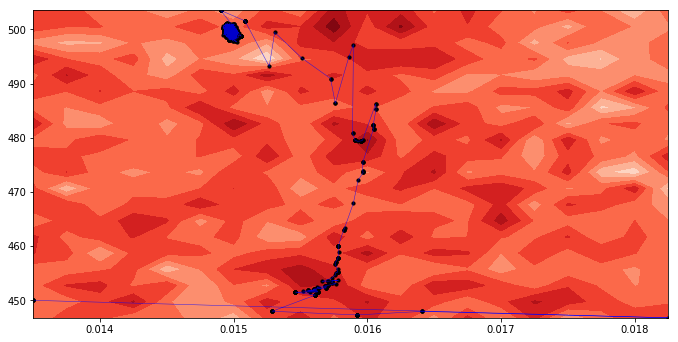

In [39]:
fig, ax = emuplt.contour(r_grid, k_grid, diffs, cmap = "Reds", fill = True)
fig.set_size_inches((10, 5))
ax.plot(r_vals, k_vals, color = 'blue', alpha = 0.8, linewidth = 0.5)
ax.scatter(r_vals, k_vals, color = 'black', s = 10)
# scatter plot causes some points to leave the axis so we need to manually specify bounds
ax.set_xlim(r_grid.min(), r_grid.max())
ax.set_ylim(k_grid.min(), k_grid.max())
plt.show()

## Further ideas
1. Automatic kernel selection
2. Active learning